In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

# Dataset preparation

In [2]:
df = pd.read_csv('../03_classification/bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]
df.y = (df.y == 'yes').astype(int)

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [4]:
seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)

val_size = 20/80

df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=seed)

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [5]:
df_full_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
14137,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
33506,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure
27524,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown
34058,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown
25922,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown


# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [6]:
numerical = df.dtypes[df.dtypes != 'object'].index.to_list()
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [7]:
scores = []

for col in ['balance', 'day', 'duration', 'previous']:
    auc = roc_auc_score(y_train, df_train[col])
    scores.append(auc)
    
    print(f"{col}: {auc}")

max(scores)

balance: 0.5888313805382317
day: 0.474042117616092
duration: 0.8147002759670778
previous: 0.5985653242764153


np.float64(0.8147002759670778)

# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [8]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [9]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [10]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)
auc.round(3)

np.float64(0.9)

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

In [11]:
threshold = np.linspace(0, 1, 101)
threshold

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [12]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    threshold = np.linspace(0, 1, 101)

    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores

In [13]:
df_model = precision_recall_dataframe(y_val, y_pred)
df_model[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,926,1489,172,6455,0.383437,0.843352
20,0.2,711,692,387,7252,0.506771,0.647541
30,0.3,565,411,533,7533,0.578893,0.514572
40,0.4,462,272,636,7672,0.629428,0.420765
50,0.5,369,193,729,7751,0.656584,0.336066
60,0.6,286,135,812,7809,0.679335,0.260474
70,0.7,224,102,874,7842,0.687117,0.204007
80,0.8,147,68,951,7876,0.683721,0.133880
90,0.9,77,27,1021,7917,0.740385,0.070128


In [14]:
df_model[df_model['precision'].round(1) == df_model['recall'].round(1)]

,threshold,tp,fp,fn,tn,precision,recall
26,0.26,623,495,475,7449,0.557245,0.567395
27,0.27,605,470,493,7474,0.562791,0.551002


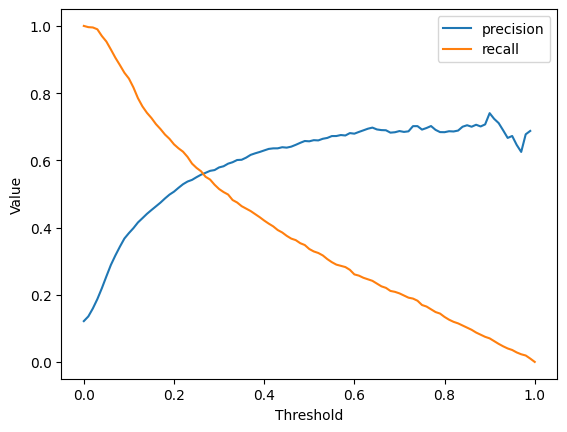

In [15]:
plt.plot(df_model.threshold, df_model.precision, label='precision')
plt.plot(df_model.threshold, df_model.recall, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [16]:
def f1_score(row):
    return 2 * ((row.precision * row.recall) / (row.precision + row.recall))

df_model['f1_score'] = df_model.apply(f1_score, axis=1)

df_model[::10]

,threshold,tp,fp,fn,tn,precision,recall,f1_score
0,0.0,1098,7944,0,0,0.121433,1.000000,0.216568
10,0.1,926,1489,172,6455,0.383437,0.843352,0.527185
20,0.2,711,692,387,7252,0.506771,0.647541,0.568573
30,0.3,565,411,533,7533,0.578893,0.514572,0.544841
40,0.4,462,272,636,7672,0.629428,0.420765,0.504367
50,0.5,369,193,729,7751,0.656584,0.336066,0.444578
60,0.6,286,135,812,7809,0.679335,0.260474,0.376564
70,0.7,224,102,874,7842,0.687117,0.204007,0.314607
80,0.8,147,68,951,7876,0.683721,0.133880,0.223915
90,0.9,77,27,1021,7917,0.740385,0.070128,0.128120


In [17]:
df_model.loc[df_model.f1_score.idxmax()]

threshold       0.220000
tp            687.000000
fp            612.000000
fn            411.000000
tn           7332.000000
precision       0.528868
recall          0.625683
f1_score        0.573217
Name: 22, dtype: float64

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [18]:
n_splits = 5

scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train['y']
    del df_val['y']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)

    scores.append(auc)

print(f"{np.mean(scores):.3f} +- {np.std(scores):.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

0.906 +- 0.006


# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [19]:
n_splits = 5

# parameter tuning the regularization parameter C
for C in [0.000001, 0.001, 1]:
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        del df_train['y']
        del df_val['y']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)

        scores.append(auc)

    print(f"C={C} -> {np.mean(scores):.3f} +- {np.std(scores):.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06 -> 0.701 +- 0.009


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001 -> 0.861 +- 0.007


  0%|          | 0/5 [00:00<?, ?it/s]

C=1 -> 0.906 +- 0.006
